# Import Packages and Dataset

In [0]:
%tensorflow_version 2.x

## Packages

In [2]:
import numpy as np
import pandas as pd

import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import GlobalAveragePooling1D

from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score,hamming_loss

from google.colab import drive
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Dataset

In [3]:
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
train_path = '/content/gdrive/My Drive/Colab Notebooks/TA/dataset/data_train_trans_full_preprocessed.csv'

data_train = pd.read_csv(train_path,sep=";")

In [5]:
data_train.head()

,Tweet,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,HS_Weak,HS_Moderate,HS_Strong,Tweet_Parsed
0,- kdg will be kind enough to show you how to l...,0,1,0,0,0,0,0,0,0,0,0,0,kadang lihat kelas teman kampung minum anggur ...
1,Ternyata komunis juga bisa nangis',0,0,0,0,0,0,0,0,0,0,0,0,nyata komunis also menang
2,USER USER Kenapa harus bom ya? Kek yg benar nu...,0,0,0,0,0,0,0,0,0,0,0,0,bom kitd suami embel bom takut orangutan orang...
3,USER Sumpaaah kaya kalo abis IAA dilanjut olim...,0,0,0,0,0,0,0,0,0,0,0,0,sumpah kaya habis iya olimpiade pagelaran budaya
4,RT USER USER USER USER USER fungsi media sosia...,1,0,1,0,0,0,0,0,1,1,0,0,medium fungsi fungsi sosial indonesia review s...


In [0]:
test_path = '/content/gdrive/My Drive/Colab Notebooks/TA/dataset/data_test_trans_full_preprocessed.csv'

data_test = pd.read_csv(test_path,sep=";")

In [7]:
data_test.head()

,Index,Tweet,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,HS_Weak,HS_Moderate,HS_Strong,Tweet_Parsed
0,1,GANTENG TAPI BERENGSEK!!! BUAT APA?!!\nWHO DO ...,1,1,1,0,0,0,0,0,1,1,0,0,ganteng berengsek pikir
1,2,Sakit jiwa kali yah..,0,0,0,0,0,0,0,0,0,0,0,0,sakit jiwa kali
2,3,"Does insulting one for being ""Cina"", ""Kafir"", ...",0,1,0,0,0,0,0,0,0,0,0,0,hina cina kafir muslim
3,4,USER USER Karena partaimu pdip itu bajingan',1,1,0,1,0,0,0,0,1,0,1,0,partai partai demokrasi indonesia juang bajing
4,5,USER USER Jgn salah itu janji jokowi yg di tun...,1,1,1,0,0,0,0,0,1,1,0,0,shalat janji jokowi tuntut paham kecebong


In [0]:
val_path = '/content/gdrive/My Drive/Colab Notebooks/TA/dataset/data_val_trans_full_preprocessed.csv'

data_val = pd.read_csv(val_path,sep=";")

In [9]:
data_val.head()

,Tweet,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,HS_Weak,HS_Moderate,HS_Strong,Tweet_Parsed
0,So much berengsek people in the world,1,1,0,1,0,0,0,0,1,0,1,0,orang berengsek dunia
1,"So, how can I get my REKBER?? rekening berengsek.",0,1,0,0,0,0,0,0,0,0,0,0,brengsek rekening rekening brengsek
2,RT USER: dasar bajingan!\xf0\x9f\x98\xa0 URL,0,1,0,0,0,0,0,0,0,0,0,0,dasar dasar bajing
3,USER Krn cebong tdk akn mengakui pria lajang y...,1,1,0,1,0,0,0,0,1,0,1,0,kecebong pria lajang lulu sastra profesor revi...
4,"RT USER: ga ada urusannya, monyet. gua broken ...",1,1,1,0,0,0,0,0,1,1,0,0,urus monyet break home teman teman kaya raya h


# Features Target Split

In [0]:
X_train = data_train['Tweet_Parsed']
y_train = data_train.drop(['Tweet','Tweet_Parsed'],axis=1)

X_val = data_val['Tweet_Parsed']
y_val = data_val.drop(['Tweet','Tweet_Parsed'],axis=1)

X_test = data_test['Tweet_Parsed']
y_test = data_test.drop(['Tweet','Tweet_Parsed','Index'],axis=1)

# Size of Vocabulary

In [0]:
vocab_size = 5000

In [12]:
vect = Tokenizer(num_words = vocab_size)
vect.fit_on_texts(X_train)
# vocab_size = len(vect.word_index)+1

print(vocab_size)

5000


# Modelling with CNN

## Padding and preparing input sequences

In [13]:
encoded_docs_train = vect.texts_to_sequences(X_train)
padded_docs_train = sequence.pad_sequences(encoded_docs_train,maxlen=100,padding='post')
print(padded_docs_train)

[[ 365   19  316 ...    0    0    0]
 [  55   22   13 ...    0    0    0]
 [ 170   25  133 ...    0    0    0]
 ...
 [4414 4415  270 ...    0    0    0]
 [ 211  209  495 ...    0    0    0]
 [ 353   35  328 ...    0    0    0]]


In [14]:
encoded_docs_val = vect.texts_to_sequences(X_val)
padded_docs_val = sequence.pad_sequences(encoded_docs_val,maxlen=100,padding='post')
print(padded_docs_val)

[[   3  152   92 ...    0    0    0]
 [ 418 2963 2963 ...    0    0    0]
 [  33   33  154 ...    0    0    0]
 ...
 [ 781  781  705 ...    0    0    0]
 [ 168   48    3 ...    0    0    0]
 [  42  592   94 ...    0    0    0]]


In [15]:
encoded_docs_test = vect.texts_to_sequences(X_test)
padded_docs_test = sequence.pad_sequences(encoded_docs_test,maxlen=100,padding='post')
print(padded_docs_test)

[[ 737  152   31 ...    0    0    0]
 [ 150  454  112 ...    0    0    0]
 [ 204   18   42 ...    0    0    0]
 ...
 [ 188   30   90 ...    0    0    0]
 [1668   77   27 ...    0    0    0]
 [ 927    7   88 ...    0    0    0]]


## Define Model

In [0]:
model = Sequential()
# Configuring the parameters
model.add(Embedding(vocab_size, output_dim=64, input_length=100))
model.add(Conv1D(128,5, activation="relu"))
model.add(GlobalAveragePooling1D())
model.add(Dense(64, activation="relu"))
model.add(Dense(12, activation="sigmoid"))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 64)           320000    
_________________________________________________________________
conv1d (Conv1D)              (None, 96, 128)           41088     
_________________________________________________________________
global_average_pooling1d (Gl (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 12)                780       
Total params: 370,124
Trainable params: 370,124
Non-trainable params: 0
_________________________________________________________________


## Training Model

In [0]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

history = model.fit(padded_docs_train, y_train.values, 
                    validation_data=(padded_docs_val, y_val.values),
                    epochs=15, batch_size=256, 
                    verbose=2)

Epoch 1/15
52/52 - 2s - loss: 0.4841 - accuracy: 0.2220 - val_loss: 0.3893 - val_accuracy: 0.1698
Epoch 2/15
52/52 - 1s - loss: 0.3821 - accuracy: 0.2484 - val_loss: 0.3857 - val_accuracy: 0.1698
Epoch 3/15
52/52 - 1s - loss: 0.3796 - accuracy: 0.1886 - val_loss: 0.3831 - val_accuracy: 0.1739
Epoch 4/15
52/52 - 1s - loss: 0.3712 - accuracy: 0.2950 - val_loss: 0.3665 - val_accuracy: 0.3852
Epoch 5/15
52/52 - 1s - loss: 0.3414 - accuracy: 0.4493 - val_loss: 0.3405 - val_accuracy: 0.4314
Epoch 6/15
52/52 - 1s - loss: 0.3108 - accuracy: 0.4737 - val_loss: 0.3258 - val_accuracy: 0.4654
Epoch 7/15
52/52 - 1s - loss: 0.2892 - accuracy: 0.4942 - val_loss: 0.3163 - val_accuracy: 0.4681
Epoch 8/15
52/52 - 1s - loss: 0.2711 - accuracy: 0.4962 - val_loss: 0.3130 - val_accuracy: 0.4416
Epoch 9/15
52/52 - 1s - loss: 0.2575 - accuracy: 0.4992 - val_loss: 0.3087 - val_accuracy: 0.4721
Epoch 10/15
52/52 - 1s - loss: 0.2461 - accuracy: 0.5014 - val_loss: 0.3094 - val_accuracy: 0.4490
Epoch 11/15
52/52 -

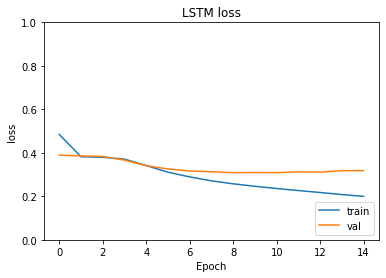

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('LSTM loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.ylim(0,1)
plt.legend(['train', 'val'], loc='lower right')
plt.show()

In [0]:
# Final evaluation of the model
scores = model.evaluate(padded_docs_test, y_test.values)

print("Accuracy: %.2f%%" % (scores[1]*100))

115/115 [==============================] - 0s 2ms/step - loss: 0.3087 - accuracy: 0.4367
Accuracy: 43.67%


# Save Model

In [0]:
model.save('/content/gdrive/My Drive/Colab Notebooks/TA/modelCNN_trans_full.h5')

In [0]:
from tensorflow.keras.models import load_model
model = load_model('/content/gdrive/My Drive/Colab Notebooks/TA/Model/5000 vocab/modelCNN_trans_full.h5')

# Predict and Result

## Predict Data Test

In [0]:
predict = model.predict(padded_docs_test)
predict_train = model.predict(padded_docs_train)
predict_val = model.predict(padded_docs_val)
thresholds=0.5

In [0]:
def labelSetAccuracy(y_true, y_pred):
    acc_list = []
    for i in range(y_true.shape[0]):
        set_true = set( np.where(y_true[i])[0] )
        set_pred = set( np.where(y_pred[i])[0] )
#         print('\nset_true: {0}'.format(set_true))
#         print('set_pred: {0}'.format(set_pred))
        tmp_a = None
        if len(set_true) == 0 and len(set_pred) == 0:
            tmp_a = 1
        else:
            tmp_a = len(set_true.intersection(set_pred))/\
                    float( len(set_true.union(set_pred)) )
        #print('tmp_a: {0}'.format(tmp_a))
        acc_list.append(tmp_a)
    return np.mean(acc_list)

In [19]:
pred_test = predict.copy()
pred_test[pred_test>=0.5] = 1
pred_test[pred_test<0.5] = 0
acc = accuracy_score(y_test.values,pred_test)
haml_loss = hamming_loss(y_test.values,pred_test)
label_acc = labelSetAccuracy(y_test.values,pred_test)
print("threshold = ",thresholds)
print("exact accuracy = ", acc)
print("hamming loss = ",haml_loss)
print("label based accuracy = ",label_acc)
print("==============================")

threshold =  0.5
exact accuracy =  0.5043478260869565
hamming loss =  0.11893115942028985
label based accuracy =  0.6282593599033817


In [20]:
pred_train = predict_train.copy()
pred_train[pred_train>=0.5] = 1
pred_train[pred_train<0.5] = 0
acc = accuracy_score(y_train.values,pred_train)
haml_loss = hamming_loss(y_train.values,pred_train)
label_acc = labelSetAccuracy(y_train.values,pred_train)
print("threshold = ",thresholds)
print("exact accuracy = ", acc)
print("hamming loss = ",haml_loss)
print("label based accuracy = ",label_acc)
print("==============================")


threshold =  0.5
exact accuracy =  0.6326638477801269
hamming loss =  0.07419712070874862
label based accuracy =  0.7694540924192087


In [21]:
pred_val = predict_val.copy()
pred_val[pred_val>=0.5] = 1
pred_val[pred_val<0.5] = 0
acc = accuracy_score(y_val.values,pred_val)
haml_loss = hamming_loss(y_val.values,pred_val)
label_acc = labelSetAccuracy(y_val.values,pred_val)
print("threshold = ",thresholds)
print("exact accuracy = ", acc)
print("hamming loss = ",haml_loss)
print("label based accuracy = ",label_acc)
print("==============================")

threshold =  0.5
exact accuracy =  0.5081521739130435
hamming loss =  0.12313179347826086
label based accuracy =  0.632531864648033


## Analysis Result

### Data Validation Predict Result Analysis

In [0]:
data_val = pd.DataFrame(data=X_val,columns=['Tweet_Parsed']).join(y_val).reset_index(drop=True)

In [23]:
data_val.head()

,Tweet_Parsed,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,HS_Weak,HS_Moderate,HS_Strong
0,orang berengsek dunia,1,1,0,1,0,0,0,0,1,0,1,0
1,brengsek rekening rekening brengsek,0,1,0,0,0,0,0,0,0,0,0,0
2,dasar dasar bajing,0,1,0,0,0,0,0,0,0,0,0,0
3,kecebong pria lajang lulu sastra profesor revi...,1,1,0,1,0,0,0,0,1,0,1,0
4,urus monyet break home teman teman kaya raya h,1,1,1,0,0,0,0,0,1,1,0,0


In [0]:
data_val_predict = pd.DataFrame(data=X_val,columns=['Tweet_Parsed']).reset_index(drop=True).join(pd.DataFrame(data=pred_val, columns=y_val.columns))

In [25]:
data_val_predict.head()

,Tweet_Parsed,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,HS_Weak,HS_Moderate,HS_Strong
0,orang berengsek dunia,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,brengsek rekening rekening brengsek,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,dasar dasar bajing,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
3,kecebong pria lajang lulu sastra profesor revi...,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,urus monyet break home teman teman kaya raya h,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Check Number of Label on Predict Data

In [0]:
label_size0_val = []
label_size1_val = []

for i in data_val.columns[1:]:
    label_size0_val.append(len(data_val[data_val[i]==0]))
    label_size1_val.append(len(data_val[data_val[i]==1]))

label_size0_val_predict = []
label_size1_val_predict = []

for i in data_val_predict.columns[1:]:
    label_size0_val_predict.append(len(data_val_predict[data_val_predict[i]==0]))
    label_size1_val_predict.append(len(data_val_predict[data_val_predict[i]==1]))

In [0]:
dat_anls_val = pd.DataFrame({
    'label' : data_val.columns[1:],
    'stats' : ["negative" for i in range(len(data_val.columns[1:]))],
    'jumlah' : label_size0_val
}).append(
    pd.DataFrame({
        'label' : data_val.columns[1:],
        'stats' : ["positive" for i in range(len(data_val.columns[1:]))],
        'jumlah' : label_size1_val
    })
)

# dat_anls_val = dat_anls_val.set_index(['label'], drop=True)

dat_anls_val_predict = pd.DataFrame({
    'label' : data_val_predict.columns[1:],
    'stats' : ["negative" for i in range(len(data_val_predict.columns[1:]))],
    'jumlah' : label_size0_val_predict
}).append(
    pd.DataFrame({
        'label' : data_val_predict.columns[1:],
        'stats' : ["positive" for i in range(len(data_val_predict.columns[1:]))],
        'jumlah' : label_size1_val_predict
    })
)

# dat_anls_val_predict = dat_anls_val_predict.set_index(['label'], drop=True)

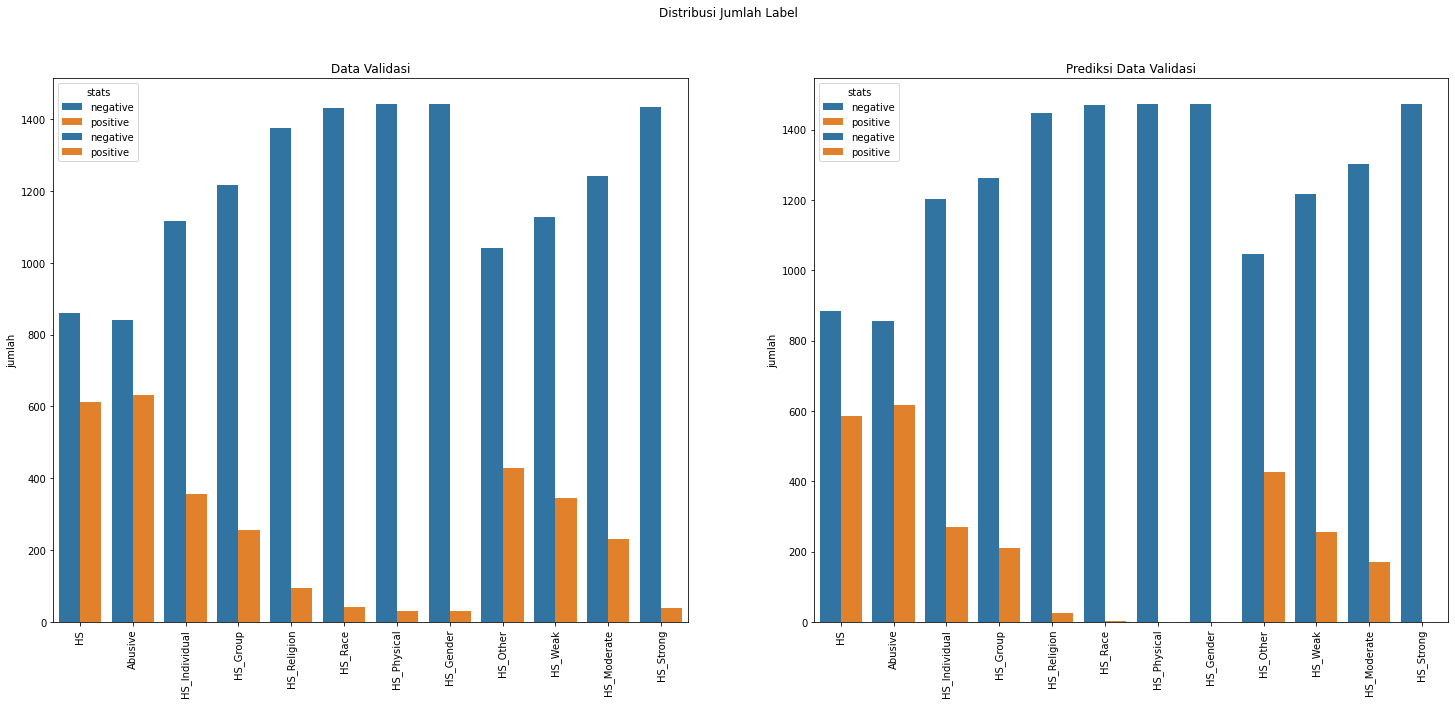

In [28]:
plt.figure(figsize=(25,10))
plt.suptitle('Distribusi Jumlah Label')

plt.subplot(1,2,1)
sns.barplot(x="label", y="jumlah",hue="stats", data=dat_anls_val).set_xticklabels(sns.barplot(x="label", y="jumlah",hue="stats", data=dat_anls_val).get_xticklabels(),rotation=90)
plt.title("Data Validasi")
plt.xlabel('')

plt.subplot(1,2,2)
sns.barplot(x="label", y="jumlah",hue="stats", data=dat_anls_val_predict).set_xticklabels(sns.barplot(x="label", y="jumlah",hue="stats", data=dat_anls_val_predict).get_xticklabels(),rotation=90)
plt.title("Prediksi Data Validasi")
plt.xlabel('')

plt.show()

In [29]:
pd.DataFrame({
    "label" : data_val.columns[1:],
    "negative (true)" : dat_anls_val[dat_anls_val['stats'] == "negative"]["jumlah"].values,
    "positive (true)" : dat_anls_val[dat_anls_val['stats'] == "positive"]["jumlah"].values,
    "negative (predict)" : dat_anls_val_predict[dat_anls_val_predict['stats'] == "negative"]["jumlah"].values,
    "positive (predict)" : dat_anls_val_predict[dat_anls_val_predict['stats'] == "positive"]["jumlah"].values
})

,label,negative (true),positive (true),negative (predict),positive (predict)
0,HS,859,613,885,587
1,Abusive,840,632,855,617
2,HS_Individual,1115,357,1202,270
3,HS_Group,1216,256,1262,210
4,HS_Religion,1376,96,1446,26
5,HS_Race,1431,41,1470,2
6,HS_Physical,1441,31,1472,0
7,HS_Gender,1441,31,1472,0
8,HS_Other,1042,430,1046,426
9,HS_Weak,1128,344,1216,256


#### OOV Check

In [0]:
def generate_ngrams(s):
    
    # Break sentence in the token, remove empty tokens
    tokens = [token for token in s.str.split(" ") if token != ""]
    
    # Use the zip function to help us generate n-grams
    # Concatentate the tokens into ngrams and return
    ngrams = np.concatenate(tokens)
    return ngrams

def oov(fitur,token):
    outOfVocab = []
    for i in token:
        if i not in fitur:
            outOfVocab.append(i)
    return outOfVocab

def oov_count(oovList):
    oovCount = {}
    for i in oovList:
        if i in oovCount.keys():
            oovCount[i] = oovCount[i]+1
        else:
            oovCount[i] = 1
    return oovCount

In [0]:
join_data_val = data_val.join(data_val_predict.drop(['Tweet_Parsed'],axis=1),rsuffix="_predict")

In [0]:
miss_exact_tweet_val = join_data_val[(join_data_val["HS"]!=join_data_val["HS_predict"]) | (join_data_val["Abusive"] != join_data_val["Abusive_predict"]) | (join_data_val["HS_Individual"] != join_data_val["HS_Individual_predict"]) | (join_data_val["HS_Group"] != join_data_val["HS_Group_predict"]) | (join_data_val["HS_Religion"] != join_data_val["HS_Religion_predict"]) | (join_data_val["HS_Race"] != join_data_val["HS_Race"]) | (join_data_val["HS_Physical"] != join_data_val["HS_Physical_predict"]) | (join_data_val["HS_Gender"] != join_data_val["HS_Gender_predict"]) | (join_data_val["HS_Other"] != join_data_val["HS_Other_predict"]) | (join_data_val["HS_Weak_predict"] != join_data_val["HS_Weak_predict"]) | (join_data_val["HS_Moderate_predict"] != join_data_val["HS_Moderate_predict"]) | (join_data_val["HS_Strong_predict"] != join_data_val["HS_Strong_predict"])]

In [0]:
oov_val = oov(vect.index_word.values(), generate_ngrams(miss_exact_tweet_val['Tweet_Parsed']))
oov_val_count = oov_count(oov_val)

In [34]:
oov_val_count

{'': 6,
 'aborsi': 1,
 'adele': 1,
 'aksinesia': 1,
 'alia': 1,
 'alin': 2,
 'american': 1,
 'anonymous': 1,
 'antagonis': 1,
 'arifinto': 1,
 'arogansi': 1,
 'athea': 1,
 'baa': 1,
 'backpass': 2,
 'badassly': 1,
 'bai': 1,
 'baku': 1,
 'barakat': 1,
 'barter': 1,
 'beg': 1,
 'belaganya': 1,
 'bengkok': 1,
 'berlusconi': 1,
 'besan': 1,
 'bimas': 1,
 'bludger': 1,
 'borneo': 1,
 'break': 1,
 'budhis': 1,
 'budu': 1,
 'buntel': 1,
 'burj': 1,
 'butah': 1,
 'butterbean': 1,
 'cakar': 1,
 'calpis': 1,
 'catcall': 1,
 'cingkrang': 1,
 'cit': 1,
 'comunis': 1,
 'congklak': 1,
 'deandra': 1,
 'didi': 1,
 'dihadang': 1,
 'dino': 1,
 'dioksida': 1,
 'ditho': 1,
 'divalidasi': 1,
 'diz': 1,
 'downgrade': 1,
 'download': 1,
 'dress': 1,
 'dusuki': 1,
 'duts': 2,
 'egoistis': 1,
 'enong': 1,
 'escpecially': 1,
 'familier': 1,
 'feelin': 1,
 'fim': 1,
 'flashdisk': 1,
 'fly': 1,
 'fo': 1,
 'foll': 1,
 'fum': 1,
 'galakin': 1,
 'geb': 1,
 'gelimang': 1,
 'gertak': 1,
 'getek': 1,
 'geulis': 1,
 'g

In [35]:
print("number of OOV words : ", len(oov_val))
print("number of unique OOV words : ", len(oov_val_count))

number of OOV words :  285
number of unique OOV words :  265


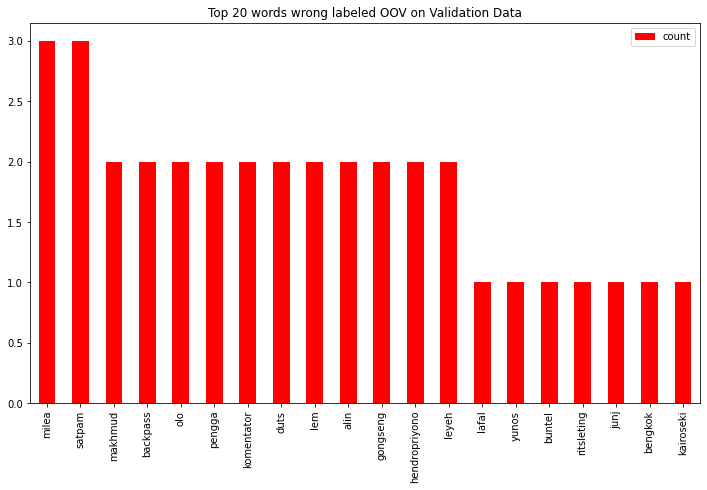

In [36]:
df_oov_val = pd.DataFrame(oov_val_count.items(),columns=["Tweet","count"])
df_oov_val.sort_values(['count'],ascending=False)[1:21].plot(
    kind='bar', y='count',x='Tweet', color='red', title='Top 20 words wrong labeled OOV on Validation Data', figsize=(12,7))
plt.xlabel("")
plt.show()

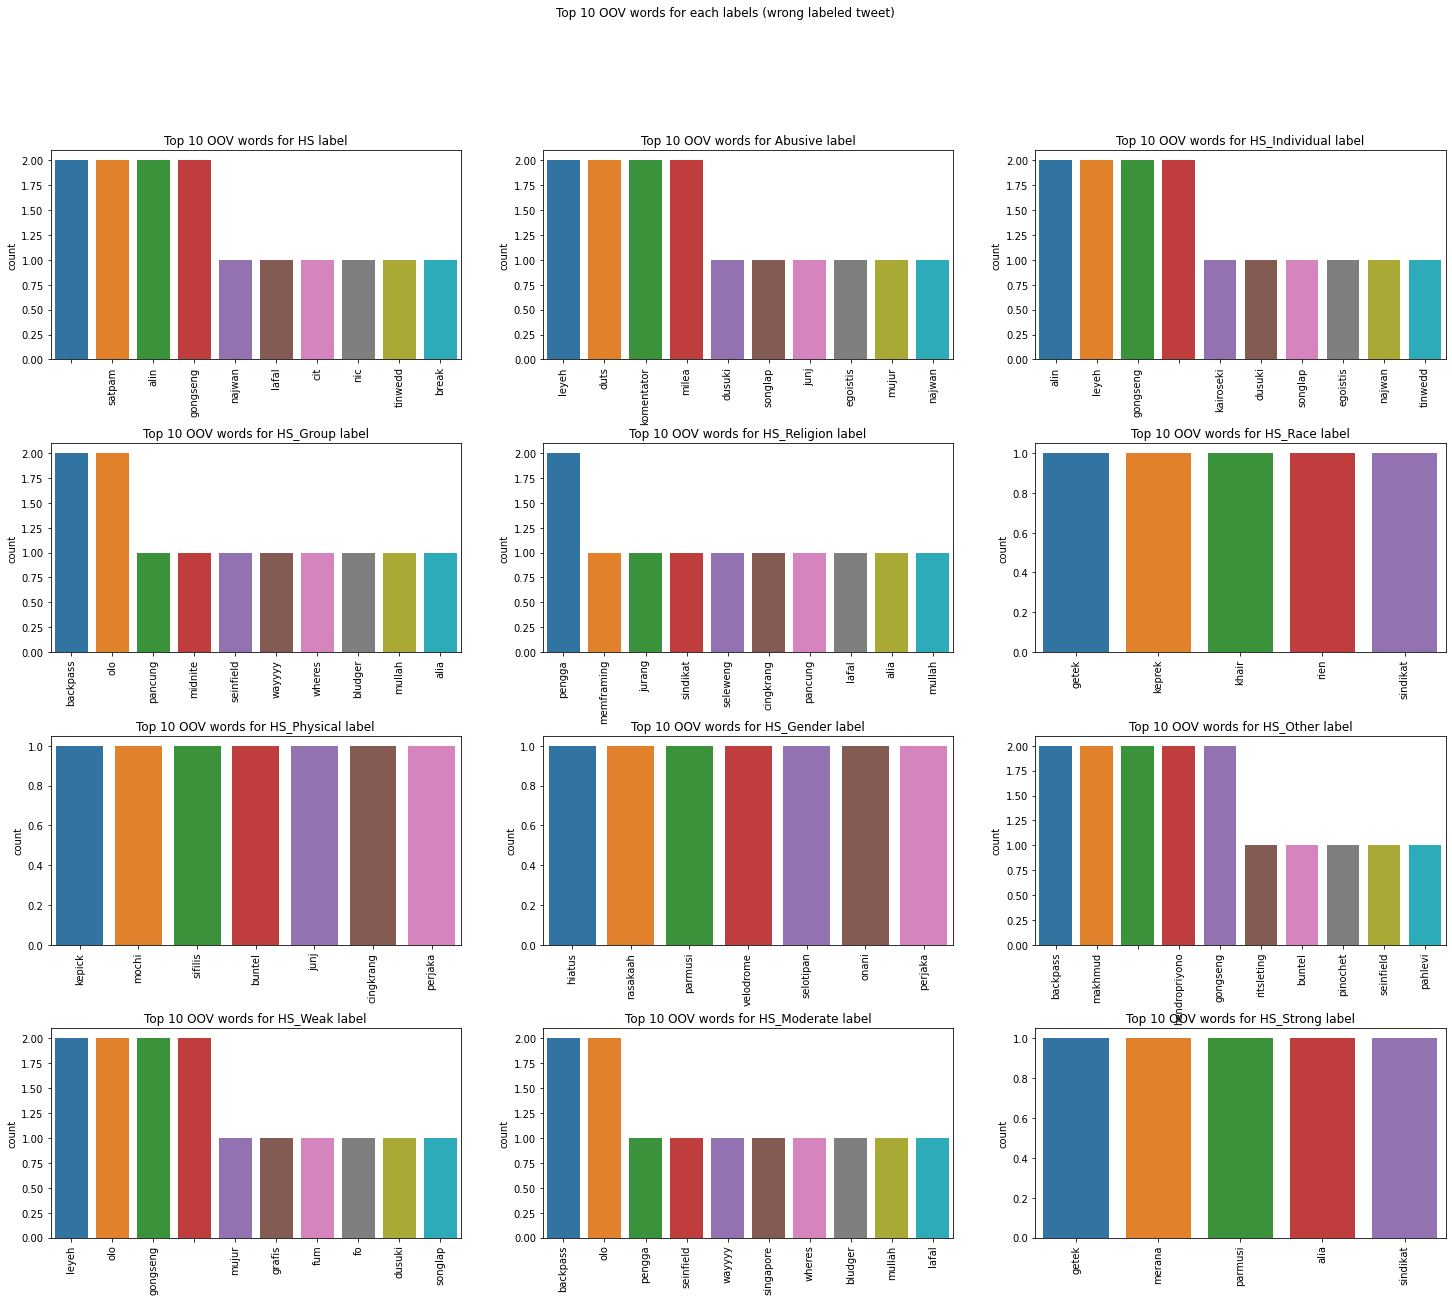

In [37]:
target = y_val.columns

plt.figure(figsize=(25,20))
plt.suptitle('Top 10 OOV words for each labels (wrong labeled tweet)')
for i in range (len(target)):
    plt.subplot(4,3,i+1)
    plt.subplots_adjust(hspace=0.4)
    wrongtweet = join_data_val[join_data_val[target[i]]!=join_data_val[target[i]+str("_predict")]]
    wrongtoken = generate_ngrams(wrongtweet['Tweet_Parsed']).tolist()
    wrong_oov = oov(vect.index_word.values(), wrongtoken)
    wrong_oov_count = oov_count(wrong_oov)
    frame = pd.DataFrame(wrong_oov_count.items(),columns=["Tweet","count"])
    frame = frame.sort_values(['count'],ascending=False)[1:11]
    sns.barplot(x="Tweet", y="count", data=frame).set_xticklabels(sns.barplot(x="Tweet", y="count", data=frame).get_xticklabels(),rotation=90)
    title='Top 10 OOV words for '+str(target[i])+" label"
    plt.title(title)
    plt.xlabel("")

#### Tweet Check

In [38]:
miss_exact_tweet_val['Tweet_Parsed'].values.tolist()

['orang berengsek dunia',
 'dasar dasar bajing',
 'kecebong pria lajang lulu sastra profesor review profesor anak tau stratum didik hasil kena pajak orang kecebong cerdas ban kampret',
 'urus monyet break home teman teman kaya raya h',
 'tai gabung tag tutup lembaga dasar',
 'celeng synna emosi mancing',
 'sinting air minum obat',
 'bacot',
 'bahas islam rusak nilai kuat karakter revitalisasi didik nilai',
 'kafir banci ampun kafir banci sedih cong google kafir banci kayak',
 'sendu gila',
 'shalat obyek aman lemah gedung dewan wakil rakyat moga sah undang undang anti terorisme dewan wakil rakyat sasar bom bunuh amin doa kabul',
 'partai demokrasi indonesia komunis',
 'ajar titik maksud anjing predator kucing mangsa pikir sekolah lelucon tertawa pantat',
 'bosan gaya monoton gaya jual citra pasang wajah melas rakyat',
 'anjir sangka kemarin sarap orangutan istirahat melulu gara gara gagal gerak gagal gerak mantan',
 'tanggal jembut',
 'tuduh partai komunis indonesia jokowi anti islam r

In [39]:
miss_exact_tweet_val.iloc[:,1:-12].columns

Index(['HS', 'Abusive', 'HS_Individual', 'HS_Group', 'HS_Religion', 'HS_Race',
       'HS_Physical', 'HS_Gender', 'HS_Other', 'HS_Weak', 'HS_Moderate',
       'HS_Strong'],
      dtype='object')

In [40]:
miss_exact_tweet_val.iloc[:,-12:].values.tolist()

[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0],
 [1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0],
 [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0],
 [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0],
 [1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0

### Data Test Predict Result Analysis

In [0]:
data_test_predict = pd.DataFrame(data=data_test['Tweet'],columns=['Tweet']).reset_index(drop=True).join(pd.DataFrame(data=pred_test, columns=y_test.columns)).join(pd.DataFrame(data=data_test['Tweet_Parsed'],columns=['Tweet_Parsed']).reset_index(drop=True))

#### Check Number of Label on Predict Data

In [0]:
label_size0_test = []
label_size1_test = []

for i in data_test.columns[2:-1]:
    label_size0_test.append(len(data_test[data_test[i]==0]))
    label_size1_test.append(len(data_test[data_test[i]==1]))

label_size0_test_predict = []
label_size1_test_predict = []

for i in data_test_predict.columns[1:-1]:
    label_size0_test_predict.append(len(data_test_predict[data_test_predict[i]==0]))
    label_size1_test_predict.append(len(data_test_predict[data_test_predict[i]==1]))

In [0]:
dat_anls_test = pd.DataFrame({
    'label' : data_test.columns[2:-1],
    'stats' : ["negative" for i in range(len(data_test.columns[2:-1]))],
    'jumlah' : label_size0_test
}).append(
    pd.DataFrame({
        'label' : data_test.columns[2:-1],
        'stats' : ["positive" for i in range(len(data_test.columns[2:-1]))],
        'jumlah' : label_size1_test
    })
)

# dat_anls_test = dat_anls_test.set_index(['label'], drop=True)

dat_anls_test_predict = pd.DataFrame({
    'label' : data_test_predict.columns[1:-1],
    'stats' : ["negative" for i in range(len(data_test_predict.columns[1:-1]))],
    'jumlah' : label_size0_test_predict
}).append(
    pd.DataFrame({
        'label' : data_test_predict.columns[1:-1],
        'stats' : ["positive" for i in range(len(data_test_predict.columns[1:-1]))],
        'jumlah' : label_size1_test_predict
    })
)

# dat_anls_test_predict = dat_anls_test_predict.set_index(['label'], drop=True)

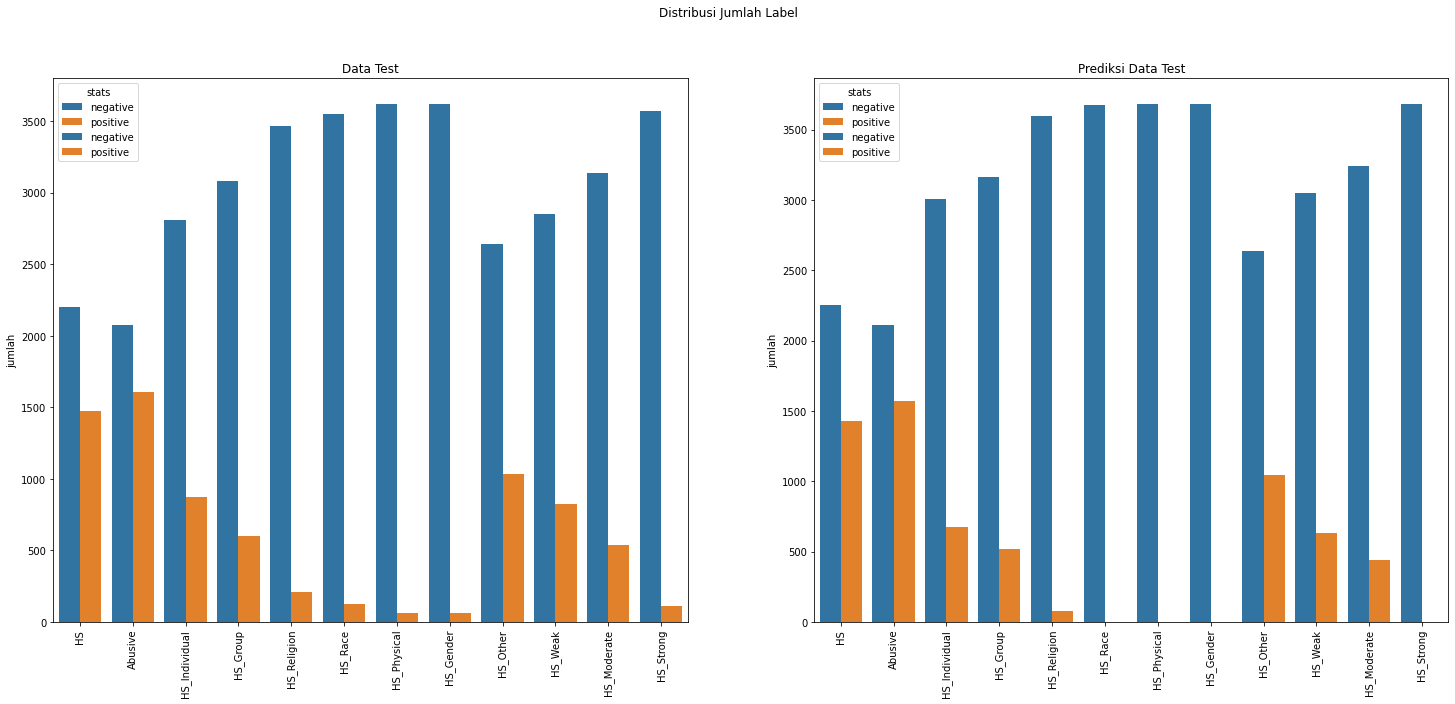

In [44]:
plt.figure(figsize=(25,10))
plt.suptitle('Distribusi Jumlah Label')

plt.subplot(1,2,1)
sns.barplot(x="label", y="jumlah",hue="stats", data=dat_anls_test).set_xticklabels(sns.barplot(x="label", y="jumlah",hue="stats", data=dat_anls_test).get_xticklabels(),rotation=90)
plt.title("Data Test")
plt.xlabel('')

plt.subplot(1,2,2)
sns.barplot(x="label", y="jumlah",hue="stats", data=dat_anls_test_predict).set_xticklabels(sns.barplot(x="label", y="jumlah",hue="stats", data=dat_anls_test_predict).get_xticklabels(),rotation=90)
plt.title("Prediksi Data Test")
plt.xlabel('')

plt.show()

In [45]:
pd.DataFrame({
    "label" : data_test.columns[2:-1],
    "negative (true)" : dat_anls_test[dat_anls_test['stats'] == "negative"]["jumlah"].values,
    "positive (true)" : dat_anls_test[dat_anls_test['stats'] == "positive"]["jumlah"].values,
    "negative (predict)" : dat_anls_test_predict[dat_anls_test_predict['stats'] == "negative"]["jumlah"].values,
    "positive (predict)" : dat_anls_test_predict[dat_anls_test_predict['stats'] == "positive"]["jumlah"].values
})

,label,negative (true),positive (true),negative (predict),positive (predict)
0,HS,2204,1476,2251,1429
1,Abusive,2075,1605,2109,1571
2,HS_Individual,2806,874,3006,674
3,HS_Group,3078,602,3160,520
4,HS_Religion,3467,213,3600,80
5,HS_Race,3551,129,3678,2
6,HS_Physical,3617,63,3680,0
7,HS_Gender,3616,64,3680,0
8,HS_Other,2643,1037,2638,1042
9,HS_Weak,2854,826,3047,633


#### OOV Check

In [0]:
join_data_test = data_test.join(data_test_predict.drop(['Tweet','Tweet_Parsed'],axis=1),rsuffix="_predict")

In [0]:
miss_exact_tweet_test = join_data_test[(join_data_test["HS"]!=join_data_test["HS_predict"]) | (join_data_test["Abusive"] != join_data_test["Abusive_predict"]) | (join_data_test["HS_Individual"] != join_data_test["HS_Individual_predict"]) | (join_data_test["HS_Group"] != join_data_test["HS_Group_predict"]) | (join_data_test["HS_Religion"] != join_data_test["HS_Religion_predict"]) | (join_data_test["HS_Race"] != join_data_test["HS_Race_predict"]) | (join_data_test["HS_Physical"] != join_data_test["HS_Physical_predict"]) | (join_data_test["HS_Gender"] != join_data_test["HS_Gender_predict"]) | (join_data_test["HS_Other"] != join_data_test["HS_Other_predict"]) | (join_data_test["HS_Weak"] != join_data_test["HS_Weak_predict"]) | (join_data_test["HS_Moderate"] != join_data_test["HS_Moderate_predict"]) | (join_data_test["HS_Strong"] != join_data_test["HS_Strong_predict"])]

In [0]:
oov_test = oov(vect.index_word.values(), generate_ngrams(miss_exact_tweet_test['Tweet_Parsed']))
oov_test_count = oov_count(oov_test)

In [49]:
oov_test_count

{'': 24,
 'aaaaaaaaaaaaaaa': 1,
 'ackerman': 1,
 'addie': 1,
 'adora': 1,
 'aec': 1,
 'afai': 1,
 'afno': 1,
 'afterall': 1,
 'agel': 1,
 'agnesmo': 1,
 'alina': 1,
 'alpha': 1,
 'alucard': 1,
 'amira': 1,
 'anaconda': 1,
 'angle': 1,
 'anjiiirr': 1,
 'anon': 1,
 'ante': 1,
 'apprently': 1,
 'ardhog': 1,
 'ardil': 1,
 'asesoris': 1,
 'ashraf': 1,
 'asri': 2,
 'atip': 1,
 'atong': 1,
 'attaturk': 1,
 'auti': 2,
 'babang': 3,
 'back': 1,
 'badik': 1,
 'bagak': 1,
 'bahana': 1,
 'baja': 1,
 'bajigur': 1,
 'bajul': 1,
 'bakery': 1,
 'bale': 1,
 'bangsar': 1,
 'bantat': 1,
 'baperki': 1,
 'barter': 1,
 'batch': 1,
 'bebal': 2,
 'belia': 1,
 'benalu': 1,
 'berang': 1,
 'berkotey': 1,
 'bersyariah': 1,
 'besengek': 1,
 'beyek': 1,
 'bhencho': 1,
 'bich': 1,
 'bidah': 1,
 'bihun': 1,
 'bingai': 1,
 'bish': 1,
 'bjp': 1,
 'blo': 1,
 'boba': 1,
 'bogan': 1,
 'bokirnya': 1,
 'boraks': 1,
 'bosch': 1,
 'bounce': 1,
 'bowie': 1,
 'box': 1,
 'bromo': 1,
 'bubu': 1,
 'bude': 1,
 'buh': 1,
 'buletin':

In [50]:
print("number of OOV words : ", len(oov_test))
print("number of unique OOV words : ", len(oov_test_count))

number of OOV words :  828
number of unique OOV words :  719


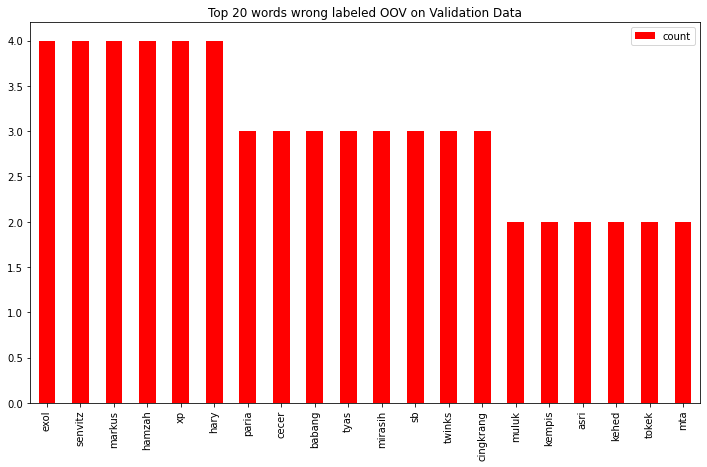

In [51]:
df_oov_test = pd.DataFrame(oov_test_count.items(),columns=["Tweet","count"])
df_oov_test.sort_values(['count'],ascending=False)[1:21].plot(
    kind='bar', y='count',x='Tweet', color='red', title='Top 20 words wrong labeled OOV on Validation Data', figsize=(12,7))
plt.xlabel("")
plt.show()

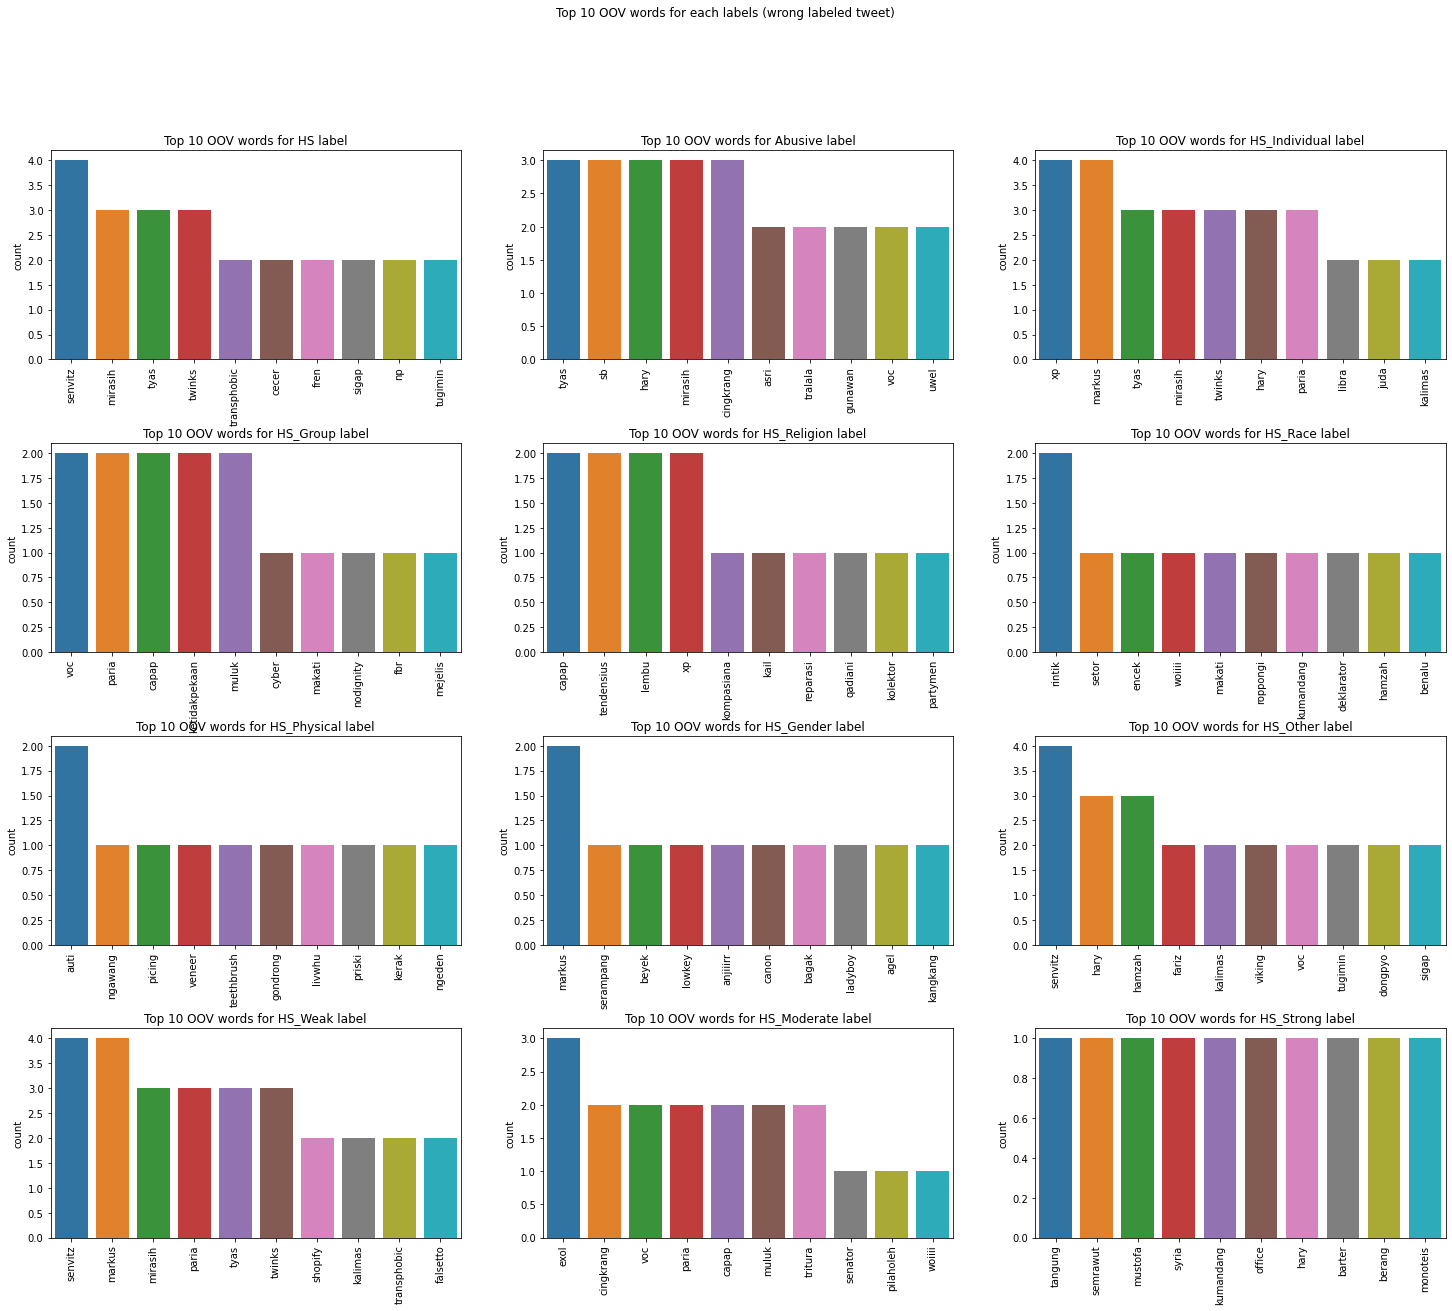

In [52]:
target = y_test.columns

plt.figure(figsize=(25,20))
plt.suptitle('Top 10 OOV words for each labels (wrong labeled tweet)')
for i in range (len(target)):
    plt.subplot(4,3,i+1)
    plt.subplots_adjust(hspace=0.4)
    wrongtweet = join_data_test[join_data_test[target[i]]!=join_data_test[target[i]+str("_predict")]]
    wrongtoken = generate_ngrams(wrongtweet['Tweet_Parsed']).tolist()
    wrong_oov = oov(vect.index_word.values(), wrongtoken)
    wrong_oov_count = oov_count(wrong_oov)
    frame = pd.DataFrame(wrong_oov_count.items(),columns=["Tweet","count"])
    frame = frame.sort_values(['count'],ascending=False)[1:11]
    sns.barplot(x="Tweet", y="count", data=frame).set_xticklabels(sns.barplot(x="Tweet", y="count", data=frame).get_xticklabels(),rotation=90)
    title='Top 10 OOV words for '+str(target[i])+" label"
    plt.title(title)
    plt.xlabel("")

#### Tweet Check

In [53]:
miss_exact_tweet_test['Tweet'].values.tolist()

["GANTENG TAPI BERENGSEK!!! BUAT APA?!!\nWHO DO YOU THINK YOU ARE? YOU'RE NOTHING!! TO ME! << REMEMBER THIS!!",
 'Sakit jiwa kali yah..',
 'Does insulting one for being "Cina", "Kafir", make you a better Muslim?',
 "USER USER Karena partaimu pdip itu bajingan'",
 "USER Khan yg ngajarin si garong kafir'",
 "USER Anak pecun... ga jauh2 dr hobi zina.. haha'",
 'USER Udah siap di demo berjilid2 sama bani cingkrang ? Malaysia memberlakukan syariat Islam, tapi melegalkan perjudian dengan berbagai syarat dan ketentuan yg "strict".\'',
 "Hamdalah. Kelar juga ini fitur keparat.'",
 "USER Jancuk! Pingin gue tabok itu anak'",
 "USER Sebenernya siapa sih yang mempunyai hak untuk menyatakan bahwa orang itu kafir? Dan jika semua orang mempunyai hak, apa kriteria kafir itu?'",
 'indonesia: literally suffocating from the air pollution\n\nthe kampungan people watching over their trash burning:  pic.twitter.com/4ny5B7F2uX',
 '#MataNajwaDebatJakarta lucu banget jawaban ahok.. gak nyambung. Ditanya apa di

In [54]:
miss_exact_tweet_test['Tweet_Parsed'].values.tolist()

['ganteng berengsek pikir',
 'sakit jiwa kali',
 'hina cina kafir muslim',
 'partai partai demokrasi indonesia juang bajing',
 'ajar garong kafir',
 'anak pecun hobi zina',
 'demo jilid jilid ban cingkrang malaysia laku syariat islam legal judi different syarat ketat',
 'hamdalah selesai also nyanyi fitur keparat',
 'jancuk tabok anak',
 'hak review nyata orangutan kafir orangutan hak kriteria kafir',
 'indonesia harfiah cekik polusi udara orang orang kampung tonton bakar sampah',
 'mata najwa debat jakarta lucu banget ahok sambung kena sekak mat isu agama dasar dasar cina tolol',
 'kecuali hizbut tahrir indonesia bela islam',
 'anjir favorit banget',
 'bodoh makan upil',
 'tipu menang beda malu cundang malaysia laut game',
 'babi najis orangutan kotor anggap minum air kencing sub benua konteks ala halang pikir lie goda',
 'kerja selesai kerja kerja pantat tk bos tingkat terampil kerja laku puas cinta kantor bangsat',
 'doe tampil bio palsu bohong kau bohong suka bohong bangga henti bo

In [55]:
miss_exact_tweet_test.iloc[:,2:-13].columns

Index(['HS', 'Abusive', 'HS_Individual', 'HS_Group', 'HS_Religion', 'HS_Race',
       'HS_Physical', 'HS_Gender', 'HS_Other', 'HS_Weak', 'HS_Moderate',
       'HS_Strong'],
      dtype='object')

In [56]:
# real label
miss_exact_tweet_test.iloc[:,2:-13].values.tolist()

[[1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0],
 [1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0],
 [1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0],
 [1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0],
 [1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0],
 [1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1],
 [1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [1, 0, 1, 0, 0, 0, 0, 0,

In [57]:
miss_exact_tweet_test.iloc[:,-12:].values.tolist()

[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0],
 [1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0],
 [1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
 [1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0],
 [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0],
 [1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0],
 [1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

In [0]:
miss_exact_tweet_test.to_csv("/content/gdrive/My Drive/Colab Notebooks/TA/bestresult_CNN_full.csv",index=False,sep=";")